In [1]:
import gdown
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
train_file_id = '19QNXPVu3UhIOHrcr2V_O64Uwu43QIO0U'
train_output_file = 'train.csv'  

train_download_url = f'https://drive.google.com/uc?id={train_file_id}'

gdown.download(train_download_url, train_output_file, quiet=False)

df = pd.read_csv(train_output_file)

Downloading...
From: https://drive.google.com/uc?id=19QNXPVu3UhIOHrcr2V_O64Uwu43QIO0U
To: d:\Document\Bangkit\Regression\train.csv
100%|██████████| 101k/101k [00:00<00:00, 28.3MB/s]


# Data Information

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
variables = [col for col in df.columns if df[col].nunique() <= 10]
for var in variables:
  print(f"====={var}=====")
  unique_values = df[var].unique()
  n_unique_values = df[var].nunique()
  value_counts = df[var].value_counts()

  print(f"Unique values in {var}: {unique_values}")
  print(f"Number of unique values in {var}: {n_unique_values}")
  print(f"Value counts in {var}:\n{value_counts}\n")

=====quality=====
Unique values in quality: [5 6 7 4 8 3]
Number of unique values in quality: 6
Value counts in quality:
quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64



# Feature Engineering

## Encoding

In [6]:
le = LabelEncoder()
df['quality'] = le.fit_transform(df['quality'])

## Scaler

In [7]:
scaler = StandardScaler()
features = [features for features in df.columns if df[features].dtype != int]
df[features] = scaler.fit_transform(df[features])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.787823
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.787823
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0.450848
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823


# Modelling

## Train test split

In [8]:
features = [col for col in df.columns if col not in ['quality']]
target = 'quality'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['acc']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=1e-5
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc', patience=5, verbose=1, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

model.summary()

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - acc: 0.0000e+00 - loss: 0.3205 - val_acc: 0.0000e+00 - val_loss: -0.4558 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.0000e+00 - loss: -1.1012 - val_acc: 0.0000e+00 - val_loss: -2.8874 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.0000e+00 - loss: -4.8997 - val_acc: 0.0000e+00 - val_loss: -9.8833 - learning_rate: 0.0010
Epoch 4/100
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.0000e+00 - loss: -14.4012
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.0000e+00 - loss: -15.6669 - val_acc: 0.0000e+00 - val_loss: -26.4280 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.0000e+00 - loss: -34.7696 - val_acc: 0.0000e+00 - val_loss: -39.9358 - learning_rate: 5.0000e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.0000e+00 - loss: -48.4

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,573 (115.52 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,716 (77.02 KB)

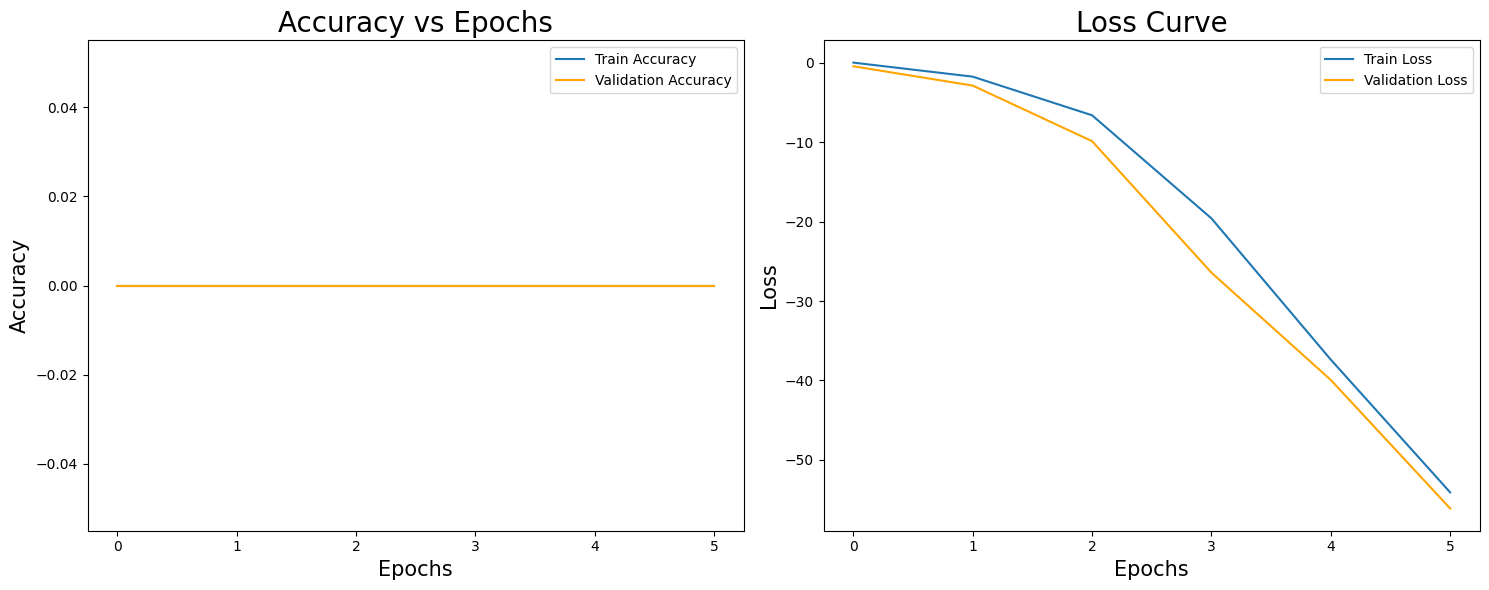

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(history.epoch, history.history['acc'], label='Train Accuracy')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation Accuracy', color='orange')
ax1.set_title('Accuracy vs Epochs', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=15)
ax1.set_ylabel('Accuracy', fontsize=15)
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], label='Train Loss')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Loss Curve', fontsize=20)
ax2.set_xlabel('Epochs', fontsize=15)
ax2.set_ylabel('Loss', fontsize=15)
ax2.legend()

plt.tight_layout()
plt.show()